### Load the required libraries for everything

In [1]:
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from keras.preprocessing import image as keras_image
from keras.optimizers import Adam, RMSprop, SGD
from keras.backend import tf as ktf
from keras.constraints import maxnorm
import keras.backend as K

import numpy as np

from collections import Counter

import os

from scipy.io import wavfile
from scipy import signal

from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd

import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.
C:\Users\dhenrichs\AppData\Local\Continuum\anaconda3\envs\deep_learn_gobble\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dhenrichs\AppData\Local\Continuum\anaconda3\envs\deep_learn_gobble\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dhenrichs\AppData\Local\Continuum\anaconda3\envs\deep_learn_gobble\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type

### Define the size of the input images

In [2]:
image_size_x = 125
image_size_y = 49

#### The next four cells all define generators that will auto-feed images to the model for training and testing.
You will need to change the path to the folders containing the images.
Folder structure should be: <br>
> Main_folder: <br>
    >> Category_1_folder <br>
    >>> images of category 1 <p> 

   >> Category_2_folder <br>
    >>> images of category 2

In [45]:
#training data generator

folder_of_images = 'E:/CJunk/Turkey_gobble_identification/turkey_classifier_band_pass/temp/'  #images for training

#adding some modifications to allow for data augmentation (images are manipulated some to make more instances of training data)
input_photos = keras_image.ImageDataGenerator(width_shift_range=5, #randomly shift image this fraction of total width
                                        fill_mode='nearest', #how to fill in empty space after shift/rotation
                                        rescale = 1/255.) # this will force the integer values in the input to be floats between 0 and 1

#start the actual flow of images for training
photos = input_photos.flow_from_directory(folder_of_images, 
                                          color_mode='grayscale', #all ifcb images are grayscale
                                          class_mode='binary', #there are 2 classes of images 
                                          target_size=(image_size_x,image_size_y),  #squish/stretch images to this size
                                          batch_size=32,) #how many images per batch
                                          

Found 495794 images belonging to 2 classes.


In [72]:
#validation data generator

folder_of_images = 'E:/CJunk/Turkey_gobble_identification/turkey_classifier_band_pass/test/' 
#adding some modifications to allow for data augmentation (images are manipulated some to make more instances of training data)
input_photos_confusion = keras_image.ImageDataGenerator(rescale = 1/255.)

#start the actual flow of images for training
photos_confusion = input_photos_confusion.flow_from_directory(folder_of_images, 
                                          shuffle=False,
                                          color_mode='grayscale', #all ifcb images are grayscale
                                          class_mode='binary', #there are 2 classes of images 
                                          target_size=(image_size_x,image_size_y),  #squish/stretch images to this size
                                          batch_size=16) #how many images per batch

Found 96907 images belonging to 2 classes.


In [46]:
#training data generator

folder_of_images = 'E:/CJunk/Turkey_gobble_identification/turkey_classifier_band_pass/temp/'  

#adding some modifications to allow for data augmentation (images are manipulated some to make more instances of training data)
input_photos_testing = keras_image.ImageDataGenerator(rescale = 1/255.)

#start the actual flow of images for training
photos_testing = input_photos.flow_from_directory(folder_of_images, 
                                          shuffle=False,
                                          color_mode='grayscale', #all ifcb images are grayscale
                                          class_mode='binary', #there are 2 classes of images
                                          target_size=(image_size_x,image_size_y),  #squish/stretch images to this size
                                          batch_size=16,) #how many images per batch
                                          

Found 495794 images belonging to 2 classes.


In [73]:
#validation data generator

folder_of_images = 'E:/CJunk/Turkey_gobble_identification/turkey_classifier_band_pass/test/'  #images for training
#adding some modifications to allow for data augmentation (images are manipulated some to make more instances of training data)
input_photos_validation = keras_image.ImageDataGenerator(rescale = 1/255.)

#start the actual flow of images for training
photos_validation = input_photos_validation.flow_from_directory(folder_of_images, 
                                          #shuffle=False,
                                          color_mode='grayscale', #all ifcb images are grayscale
                                          class_mode='binary', #there are 2 classes of images
                                          target_size=(image_size_x,image_size_y),  #squish/stretch images to this size
                                          batch_size=16) #how many images per batch

Found 96907 images belonging to 2 classes.


### Here is where the structure of the CNN model is defined

In [9]:
#Functional API version of the model

inputs = Input((image_size_x,image_size_y, 1))

conv1 = Conv2D(16, (5,5), padding='same', strides=1)(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)

conv3 = Conv2D(64, (3,3), padding='same', strides=1)(conv1)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)

conv7 = Conv2D(128, (3,3), padding='same')(conv3)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)
conv7 = MaxPooling2D(pool_size=(2,2))(conv7)

conv8 = Conv2D(256, (3,3), padding='same')(conv7)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)
conv8 = MaxPooling2D(pool_size=(2,2))(conv8)
conv8 = MaxPooling2D(pool_size=(2,2))(conv8)

flat = Flatten()(conv8)
flat = Dense(1024, kernel_constraint=maxnorm(3))(flat)
flat = Activation('relu')(flat)
flat = Dropout(0.35)(flat)
flat = Dense(512, kernel_constraint=maxnorm(3))(flat)
flat = Activation('relu')(flat)

finish = Dropout(0.35)(flat)
finish = Dense(1)(finish)
finish = Activation('sigmoid')(finish)

model = Model(inputs=[inputs], outputs=[finish])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Here we decide what optimizer to use and what learning rate, etc. to use. <br> 
Adam is one of the more commonly used optimizer suitable for a wide range of situations. 

In [104]:
adam = Adam(lr=0.0000001, decay=.00000025)
#sgd = SGD()
#rms = RMSprop()

### Model needs to be compiled before training <br>
Warnings may pop up here but for now, they're okay to ignore. They're letting us know that certain functions are going to be removed in future releases. Since these functions reside in Keras, the Keras group should take care of changing out the functions/names in a future release. 

In [105]:
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy', 'mse'],
             )

### Let's take a look at the model structure and see how many parameters it has for training. 

In [12]:
print(model.count_params())
print(model.summary())

1693345
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 49, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 49, 16)       416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 49, 16)       64        
_________________________________________________________________
activation_1 (Activation)    (None, 125, 49, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 24, 64)        9280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 24, 64)        256       
__

### The categories of images are often imbalanced (not equal numbers of training images in each category). <br>
To correct for this, we alter the weight (impact on training) of the categories to help categories with low numbers of images. 

In [13]:
#try this function to correct for imbalanced classes
#the code for this function was copied from here:
# https://gist.github.com/cbaziotis/f8ffa9922081493418287ee14830e6e9

def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}



In [87]:
temp_class_weights = get_class_weights(photos.classes, 0.1)
temp_class_weights

{0: 5.45276226753453, 1: 1.0}

### The model is starting to be trained now. <br>
Output for the training is stored in the `hist` variable but the `model` itself is what's being trained. The `hist` variable will store the loss values, the accuracy values, etc. for later plotting. 

In [133]:
num_images = len(photos.classes)
batch_size=32
hist = model.fit_generator(photos, #the generator defined above for training
            steps_per_epoch=int(num_images/batch_size), #how many sets of images (of size = batch_size) will be looked at each epoch
            epochs=50, #how many epochs to run
            initial_epoch=45, #which epoch do you want to start from? useful when continuing training
            validation_data = photos_validation, #generator for validation images; should be different than the training images
            validation_steps = 2000, #how many batches of images to run through for validation calculation
            class_weight=temp_class_weights,  #this is to help with the unbalanced class issue
            )

Epoch 46/50
15493/15493 [==============================] - 283s 18ms/step - loss: 0.0120 - acc: 0.9975 - mean_squared_error: 0.0019 - val_loss: 0.3135 - val_acc: 0.9637 - val_mean_squared_error: 0.0328
Epoch 47/50
15493/15493 [==============================] - 284s 18ms/step - loss: 0.0120 - acc: 0.9975 - mean_squared_error: 0.0019 - val_loss: 0.3055 - val_acc: 0.9637 - val_mean_squared_error: 0.0327
Epoch 48/50
15493/15493 [==============================] - 283s 18ms/step - loss: 0.0119 - acc: 0.9974 - mean_squared_error: 0.0019 - val_loss: 0.3172 - val_acc: 0.9618 - val_mean_squared_error: 0.0338
Epoch 49/50
15493/15493 [==============================] - 284s 18ms/step - loss: 0.0127 - acc: 0.9974 - mean_squared_error: 0.0019 - val_loss: 0.3047 - val_acc: 0.9646 - val_mean_squared_error: 0.0321
Epoch 50/50
15493/15493 [==============================] - 283s 18ms/step - loss: 0.0114 - acc: 0.9975 - mean_squared_error: 0.0019 - val_loss: 0.3028 - val_acc: 0.9647 - val_mean_squared_erro

### Run the cell below to save the model to a path/filename that you define. <br>
#### Caution: it WILL overwrite a file without asking

In [134]:
model.save('E:/CJunk/Turkey_gobble_identification/turkey_classifier/model_18Dec2019_bandpass_50_epochs.mdl')


### Run the cell below to load a model from a saved file.

In [52]:
model = load_model('E:/CJunk/Turkey_gobble_identification/turkey_classifier/model_26Nov2019_small_50_epochs.mdl')
#the model== model_26Nov2019_small_50_epochs.mdl does very well

In [7]:
model = load_model('E:/CJunk/Turkey_gobble_identification/turkey_classifier/model_16Dec2019_35_epochs.mdl')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Now to check how well the model is doing based on the testing set. <br>
These cells will run all of the images in the photos_confusion generator through the CNN and compare the output with the true value.

In [135]:
num_images = len(photos_confusion.classes)
photos_confusion.reset()
Y_pred = model.predict_generator(photos_confusion, num_images/16 + 1)
y_pred = np.round(Y_pred)

In [136]:
print('Confusion Matrix')
print(confusion_matrix(photos_confusion.classes, y_pred[:num_images]))
check_answer = np.sort(list(photos_confusion.class_indices))
print('Classification Report')
target_names = check_answer
print(classification_report(photos_confusion.classes, y_pred[:num_images], target_names=target_names))

Confusion Matrix
[[10166  2345]
 [ 1171 83225]]
Classification Report
              precision    recall  f1-score   support

      gobble       0.90      0.81      0.85     12511
       other       0.97      0.99      0.98     84396

    accuracy                           0.96     96907
   macro avg       0.93      0.90      0.92     96907
weighted avg       0.96      0.96      0.96     96907



In [91]:
conf_mat = pd.DataFrame(confusion_matrix(photos_confusion.classes, y_pred[:num_images]), columns=target_names, index=target_names)
conf_mat

,gobble,other
gobble,10121,2390
other,1121,83275


In [423]:
conf_mat = pd.DataFrame(confusion_matrix(photos_confusion.classes, y_pred[:num_images]), columns=target_names, index=target_names)
conf_mat

,gobble,other
gobble,10477,1756
other,1599,82690


### Now to run the training set through the CNN to see how well the model fits/overfits

In [255]:
num_images = len(photos_testing.classes)
photos_testing.reset()
Y_pred = model.predict_generator(photos_testing, num_images/16 + 1)
y_pred = np.round(Y_pred)

In [256]:
print('Confusion Matrix')
print(confusion_matrix(photos_testing.classes, y_pred[:num_images]))
check_answer = np.sort(list(photos_testing.class_indices))
print('Classification Report')
target_names = check_answer
print(classification_report(photos_testing.classes, y_pred[:num_images], target_names=target_names))

Confusion Matrix
[[ 41303    350]
 [   574 308096]]
Classification Report
              precision    recall  f1-score   support

      gobble       0.99      0.99      0.99     41653
       other       1.00      1.00      1.00    308670

    accuracy                           1.00    350323
   macro avg       0.99      0.99      0.99    350323
weighted avg       1.00      1.00      1.00    350323



In [257]:
conf_mat = pd.DataFrame(confusion_matrix(photos_testing.classes, y_pred[:num_images]), columns=target_names, index=target_names)
conf_mat

,gobble,other
gobble,41303,350
other,574,308096


### The cell below contains the main code to load a WAV file and run it through the CNN. <br>
I've added a variable `temp_audio_out` where the audio snippets will be placed. You can obviously put this wherever you want. 

In [4]:
#batch version of this function
temp_audio_out = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/audio_out/'
def load_classify_images(infile):
    image_size_x = 125
    image_size_y = 49
    stft_params = {'nperseg':1000, 'noverlap':500}
    stft_conversion = stft_params['nperseg'] - stft_params['noverlap']
    window_shift_size = 500 #6000 equal 0.25seconds
    window_shift_size = int(window_shift_size / stft_conversion) #convert the window shift into stft units
    inwav = wavfile.read(infile) #load the raw WAV file
    outdata = pd.DataFrame(columns=['Event', 'Start_time', 'End_time', 'Gobble', 'Model_output', 'Min:Sec', 'Start_index', 'End_index', 'Num_windows', 'Begin File'])
    infilename = infile.split('/')[-1]
    gobble_count = 1
    results = []
    track_gobble = False
    gobble_start = 0
    gobble_end = 24000
    batch_results = {'start':[], 'end':[], 'result':[]}
    img_batch = []
    f, t, Zxx = signal.stft(inwav[1], 24000, nperseg=stft_params['nperseg'], noverlap=stft_params['noverlap']) #calculate the short time Fourier transform
    Zxx = np.abs(Zxx)[25:150, :]     
    
    #generate the window slices and run them through the CNN
    for image in range(0, int(Zxx.shape[1]), window_shift_size): #go through the WAV file in 1/12th second intervals (2000)
#         if image % 10000 == 0:
#             print(image)
        start_ind = image
        end_ind = image + 48
        
        if end_ind + 48 >= int(Zxx.shape[1]): #reached the end of the WAV file; no more 2s windows available
            continue
        else:
            batch_results['start'].append(start_ind)
            batch_results['end'].append(end_ind)
            img = Zxx[:, start_ind:start_ind+image_size_y].astype('int16') #slice the resulting array down to the proper size for input into the CNN
            img = img.reshape(image_size_x,image_size_y,1) 
            img = img/255.
            img_batch.append(img)
            if len(img_batch) == 16:
                out = model.predict(np.array(img_batch)) #run the images through the CNN
                for indiv_result in out:
                    batch_results['result'].append(indiv_result)
                img_batch = []
    
    if len(img_batch) > 0: #pickup the last few windows in case it doesn't end on a clean multiple of 16
        out = model.predict(np.array(img_batch)) #run the images through the CNN
        for indiv_result in out:
            batch_results['result'].append(indiv_result)
        img_batch = []
        
    #aggregate the results of the CNN    
    for result in range(len(batch_results['start'])):
        start_ind = batch_results['start'][result] * stft_conversion #convert back to WAV files units
        end_ind = batch_results['end'][result] * stft_conversion #convert back to WAV files units
        out = batch_results['result'][result][0]
        #if round(out) == 0 and not track_gobble: #CNN said it's a gobble; start tracking the length of the gobble window
        if out < 0.4 and not track_gobble: #CNN said it's a gobble; start tracking the length of the gobble window
            track_gobble = True
            gobble_start = start_ind
            gobble_end = start_ind + 24000
            gobble_predict_value = out
            num_gobble_windows = 1
        #elif round(out) == 0: #CNN said this window is still part of the previous gobble
        elif out < 0.5 and track_gobble: #CNN said this window is still part of the previous gobble
            #if start_ind > gobble_end:
            gobble_end += int(window_shift_size * stft_conversion) #extend the window size of the gobble
            gobble_predict_value += out
            num_gobble_windows += 1
        elif track_gobble == True: #CNN said the current window is no longer a gobble; complete the logging for this gobble
            track_gobble = False
            if num_gobble_windows > 16 and gobble_predict_value/num_gobble_windows < 0.5: #gobble window must be more than 2 windows AND the average value coming from the CNN less than 0.10
                gob_st = (gobble_start/24000) / 60.
                min_sec = '{0}:{1:02}'.format(int(gob_st), round(((gob_st) - int(gob_st))*60))
                outdata.loc[gobble_count] = [gobble_count, round(gobble_start/24000,2), round(gobble_end/24000,2), 1,
                                             round(gobble_predict_value/num_gobble_windows,4), min_sec, gobble_start, gobble_end, num_gobble_windows, infilename] #add the info to the DataFrame
                gobble_count += 1
                while gobble_end - gobble_start < 96000:
                    gobble_start -= 1000
                    gobble_end += 1000
                    if gobble_start < 0:
                        gobble_start = 0
                        break
                    
                outwav = inwav[1][gobble_start:gobble_end]
                wavfile.write(temp_audio_out + infilename[:-4] + '_gobble_' + str(gobble_count - 1) + '.wav', 24000, outwav) #write the sound snippet to file
        else: #no gobble and it wasn't tracking a gobble
            pass 
        
    return outdata, batch_results['result']

### Give the path to a WAV file to run it through the CNN

In [140]:
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/test/CC20_20180414_050000.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/test/CC32_20180317_070002.wav'
dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/test/CC17_20180310_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/test/CC16_20180303_060002.wav'

In [565]:
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_090002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_100002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC20_20180414_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC20_20180414_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC20_20180414_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180301_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180314_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180314_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180315_060002.wav'
dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180315_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180316_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180406_070002.wav'


### This will actually run the function for putting the WAV file through the CNN

In [141]:
predictions, pred_scores = load_classify_images(dat)

### Here's the number of 'gobbles' that were detected by the CNN.<br>
Also, the information for the first 50 events. 

In [142]:
print(predictions.shape)
predictions[:60]

(42, 10)


,Event,Start_time,End_time,Gobble,Model_output,Min:Sec,Start_index,End_index,Num_windows,Begin File
1,1,0.00,1.42,1,0.0897,0:00,0,34000,21,CC17_20180310_070002.wav
2,2,4.85,7.08,1,0.0657,0:05,116500,170000,60,CC17_20180310_070002.wav
3,3,8.38,10.17,1,0.0985,0:08,201000,244000,39,CC17_20180310_070002.wav
4,4,37.48,39.17,1,0.0921,0:37,899500,940000,34,CC17_20180310_070002.wav
5,5,38.50,39.88,1,0.3061,0:38,924000,957000,19,CC17_20180310_070002.wav
6,6,128.44,129.92,1,0.3062,2:08,3082500,3118000,24,CC17_20180310_070002.wav
7,7,130.81,132.23,1,0.2984,2:11,3139500,3173500,21,CC17_20180310_070002.wav
8,8,146.75,148.81,1,0.0667,2:27,3522000,3571500,52,CC17_20180310_070002.wav
9,9,192.27,194.67,1,0.1675,3:12,4614500,4672000,68,CC17_20180310_070002.wav
10,10,218.12,220.08,1,0.1072,3:38,5235000,5282000,47,CC17_20180310_070002.wav


In [143]:
print(predictions.Model_output.mean())
predictions[60:120]

0.15453095238095238


,Event,Start_time,End_time,Gobble,Model_output,Min:Sec,Start_index,End_index,Num_windows,Begin File


In [41]:
print(predictions.shape)
predictions[120:180]

(86, 10)


,Event,Start_time,End_time,Gobble,Model_output,Min:Sec,Start_index,End_index,Num_windows,Begin File


In [47]:
predictions.to_csv('E:/CJunk/Turkey_gobble_identification/Darren_Data/CC32_20180317_070002_model_26Nov2019_small_40_epochs_window2000.txt', sep='\t')

In [175]:
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180312_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180316_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180524_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180301_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180315_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180317_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180406_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180423_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_080002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180314_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180409_090002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_100002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180317_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC16_20180303_090002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180318_070002.wav'
dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180413_060002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180315_070002.wav'
#dat = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/train/CC32_20180314_070002.wav'


In [49]:
predictions = load_classify_images(dat)

In [113]:
%pylab
import matplotlib
import pandas as pd
%matplotlib inline
figsize(10,15)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [506]:
plot(pred_scores[:])

hlines(0.5, 0, 44000)
xlim(0, len(pred_scores))
xvals = list((array(range(len(pred_scores)))*0.08333))
#xticks(xvals)

In [13]:
close('all')

In [114]:
xvals = list((array(range(len(pred_scores)))*(500/24000.)))
df = pd.DataFrame(pred_scores, columns=['scores'], index=xvals)

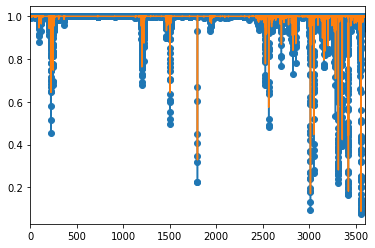

In [115]:
df.scores.plot(marker='o')
df.scores.rolling(window=6).mean().plot()

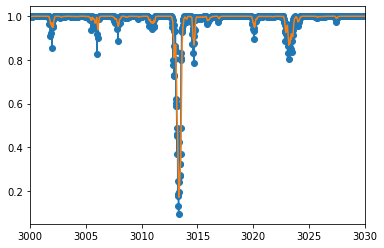

In [116]:
df.scores[3000:3030].plot(marker='o')
df.scores[3000:3030].rolling(window=6).mean().plot()

In [99]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


lowcut = 500.0
highcut = 1475.0



In [124]:
#bandpass version of this function




temp_audio_out = 'E:/CJunk/Turkey_gobble_identification/Darren_Data/audio_out/'
def load_classify_images(infile):
    image_size_x = 125
    image_size_y = 49
    stft_params = {'nperseg':1000, 'noverlap':500}
    stft_conversion = stft_params['nperseg'] - stft_params['noverlap']
    window_shift_size = 500 #6000 equal 0.25seconds
    window_shift_size = int(window_shift_size / stft_conversion) #convert the window shift into stft units
    inwav = wavfile.read(infile) #load the raw WAV file
    outdata = pd.DataFrame(columns=['Event', 'Start_time', 'End_time', 'Gobble', 'Model_output', 'Min:Sec', 'Start_index', 'End_index', 'Num_windows', 'Begin File'])
    infilename = infile.split('/')[-1]
    gobble_count = 1
    results = []
    track_gobble = False
    gobble_start = 0
    gobble_end = 24000
    batch_results = {'start':[], 'end':[], 'result':[]}
    img_batch = []
    inwav_bandpass = butter_bandpass_filter(inwav[1], lowcut, highcut, 24000, order=6)
    f, t, Zxx = signal.stft(inwav_bandpass, 24000, nperseg=stft_params['nperseg'], noverlap=stft_params['noverlap']) #calculate the short time Fourier transform
    Zxx = np.abs(Zxx)[25:150, :]     
    
    #generate the window slices and run them through the CNN
    for image in range(0, int(Zxx.shape[1]), window_shift_size): #go through the WAV file in 1/12th second intervals (2000)
#         if image % 10000 == 0:
#             print(image)
        start_ind = image
        end_ind = image + 48
        
        if end_ind + 48 >= int(Zxx.shape[1]): #reached the end of the WAV file; no more 2s windows available
            continue
        else:
            batch_results['start'].append(start_ind)
            batch_results['end'].append(end_ind)
            img = Zxx[:, start_ind:start_ind+image_size_y].astype('int16') #slice the resulting array down to the proper size for input into the CNN
            img = img.reshape(image_size_x,image_size_y,1) 
            img = img/255.
            img_batch.append(img)
            if len(img_batch) == 16:
                out = model.predict(np.array(img_batch)) #run the images through the CNN
                for indiv_result in out:
                    batch_results['result'].append(indiv_result)
                img_batch = []
    
    if len(img_batch) > 0: #pickup the last few windows in case it doesn't end on a clean multiple of 16
        out = model.predict(np.array(img_batch)) #run the images through the CNN
        for indiv_result in out:
            batch_results['result'].append(indiv_result)
        img_batch = []
        
    #aggregate the results of the CNN    
    for result in range(len(batch_results['start'])):
        start_ind = batch_results['start'][result] * stft_conversion #convert back to WAV files units
        end_ind = batch_results['end'][result] * stft_conversion #convert back to WAV files units
        out = batch_results['result'][result][0]
        #if round(out) == 0 and not track_gobble: #CNN said it's a gobble; start tracking the length of the gobble window
        if out < 0.4 and not track_gobble: #CNN said it's a gobble; start tracking the length of the gobble window
            track_gobble = True
            gobble_start = start_ind
            gobble_end = start_ind + 24000
            gobble_predict_value = out
            num_gobble_windows = 1
        #elif round(out) == 0: #CNN said this window is still part of the previous gobble
        elif out < 0.5 and track_gobble: #CNN said this window is still part of the previous gobble
            #if start_ind > gobble_end:
            gobble_end += int(window_shift_size * stft_conversion) #extend the window size of the gobble
            gobble_predict_value += out
            num_gobble_windows += 1
        elif track_gobble == True: #CNN said the current window is no longer a gobble; complete the logging for this gobble
            track_gobble = False
            if num_gobble_windows > 16 and gobble_predict_value/num_gobble_windows < 0.5: #gobble window must be more than 2 windows AND the average value coming from the CNN less than 0.10
                gob_st = (gobble_start/24000) / 60.
                min_sec = '{0}:{1:02}'.format(int(gob_st), round(((gob_st) - int(gob_st))*60))
                outdata.loc[gobble_count] = [gobble_count, round(gobble_start/24000,2), round(gobble_end/24000,2), 1,
                                             round(gobble_predict_value/num_gobble_windows,4), min_sec, gobble_start, gobble_end, num_gobble_windows, infilename] #add the info to the DataFrame
                gobble_count += 1
                while gobble_end - gobble_start < 96000:
                    gobble_start -= 1000
                    gobble_end += 1000
                    if gobble_start < 0:
                        gobble_start = 0
                        break
                    
                outwav = inwav[1][gobble_start:gobble_end]
                wavfile.write(temp_audio_out + infilename[:-4] + '_gobble_' + str(gobble_count - 1) + '.wav', 24000, outwav) #write the sound snippet to file
        else: #no gobble and it wasn't tracking a gobble
            pass 
        
    return outdata, batch_results['result']